- source: www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**A Markov Chain describes a stochastic process where the probability of future states depends only on the current process state, not on the states that preceded**

- Task: Probability of a dog is in one of three future states given its current state
- we need: state space, initial probabilities, transition probabilities

In [14]:
states = ['sleeping', 'eating', 'pooping']
state_probs = [0.35, 0.35, 0.3]
state_space = pd.Series(state_probs, index=states, name='states')

print(state_space)
print("Initial probabilites must sum up to 1:", state_space.sum())

sleeping    0.35
eating      0.35
pooping     0.30
Name: states, dtype: float64
Initial probabilites must sum up to 1: 1.0


**Transition probabilities**: staying in the same state or moving to a different state given the current state (Matrix)
- Matrix is MxM (number of states)

In [15]:
T = pd.DataFrame(columns=states, index=states)

T.loc[states[0]] = [0.4, 0.2, 0.4]
T.loc[states[1]] = [0.45, 0.45, 0.1]
T.loc[states[2]] = [0.45, 0.25, .3]

T

,sleeping,eating,pooping
sleeping,0.4,0.2,0.4
eating,0.45,0.45,0.1
pooping,0.45,0.25,0.3


In [17]:
values = T.values
print(values)
print(values.shape)

[[0.4 0.2 0.4]
 [0.45 0.45 0.1]
 [0.45 0.25 0.3]]
(3, 3)


- setting up a Markov diagram with Networkx
- a dictionary is created for this that holds edges and weights

In [18]:
from pprint import pprint 

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(T)

pprint(edges_wts)


{('eating', 'eating'): 0.45,
 ('eating', 'pooping'): 0.1,
 ('eating', 'sleeping'): 0.45,
 ('pooping', 'eating'): 0.25,
 ('pooping', 'pooping'): 0.3,
 ('pooping', 'sleeping'): 0.45,
 ('sleeping', 'eating'): 0.2,
 ('sleeping', 'pooping'): 0.4,
 ('sleeping', 'sleeping'): 0.4}


Nodes:
['sleeping', 'eating', 'pooping']

Edges:
OutMultiEdgeDataView([('sleeping', 'sleeping', {'weight': 0.4, 'label': 0.4}), ('sleeping', 'eating', {'weight': 0.2, 'label': 0.2}), ('sleeping', 'pooping', {'weight': 0.4, 'label': 0.4}), ('eating', 'sleeping', {'weight': 0.45, 'label': 0.45}), ('eating', 'eating', {'weight': 0.45, 'label': 0.45}), ('eating', 'pooping', {'weight': 0.1, 'label': 0.1}), ('pooping', 'sleeping', {'weight': 0.45, 'label': 0.45}), ('pooping', 'eating', {'weight': 0.25, 'label': 0.25}), ('pooping', 'pooping', {'weight': 0.3, 'label': 0.3})])


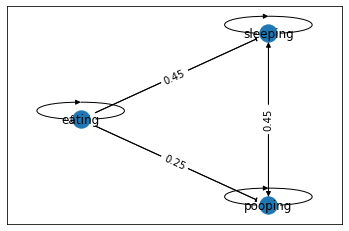

In [19]:
import networkx as nx

# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
print(f'Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_markov.dot')



## **Hidden Markov Model**

- latent/hidden variables that are unknown

In [20]:
hidden_states = ['healthy', 'sick']
hidden_probs = [0.5, 0.5]
state_space = pd.Series(hidden_probs, index=hidden_states, name='states')
state_space

healthy    0.5
sick       0.5
Name: states, dtype: float64

In [21]:
# Transition Matrix for hidden states (from and to hidden states)

T_hidden = pd.DataFrame(columns=hidden_states, index=hidden_states)
T_hidden.loc[hidden_states[0]] = [0.7, 0.3]
T_hidden.loc[hidden_states[1]] = [0.4, 0.6]

print(T_hidden)

print(T_hidden.values)
print(T_hidden.shape)
print(T_hidden.sum(axis=1))

        healthy sick
healthy     0.7  0.3
sick        0.4  0.6
[[0.7 0.3]
 [0.4 0.6]]
(2, 2)
healthy    1.0
sick       1.0
dtype: float64


- emission probability matrix M x O 
- M (number of hidden states)
- O (number of observable outcomes)

- probability of dog being in an observable state, given the hidden state!??? andersrum??


In [25]:
observable_states = ['sleeping', 'eating', 'pooping']

E = pd.DataFrame(columns=observable_states, index=hidden_states)
E.loc[hidden_states[0]] = [0.2, 0.6, 0.2]
E.loc[hidden_states[1]] = [0.4, 0.1, 0.5]
E
# p(healthy | sleeping)

,sleeping,eating,pooping
healthy,0.2,0.6,0.2
sick,0.4,0.1,0.5


In [26]:
# graph edges
# hidden transition matrix
hide_edges_wts = _get_markov_edges(T_hidden)
pprint(hide_edges_wts)

{('healthy', 'healthy'): 0.7,
 ('healthy', 'sick'): 0.3,
 ('sick', 'healthy'): 0.4,
 ('sick', 'sick'): 0.6}


In [28]:
# emission matrix 
emit_edges_wts = _get_markov_edges(E)
pprint(emit_edges_wts)

{('healthy', 'eating'): 0.6,
 ('healthy', 'pooping'): 0.2,
 ('healthy', 'sleeping'): 0.2,
 ('sick', 'eating'): 0.1,
 ('sick', 'pooping'): 0.5,
 ('sick', 'sleeping'): 0.4}


Nodes:
['healthy', 'sick']

Edges:
OutMultiEdgeDataView([('healthy', 'healthy', {'weight': 0.7, 'label': 0.7}), ('healthy', 'sick', {'weight': 0.3, 'label': 0.3}), ('healthy', 'sleeping', {'weight': 0.2, 'label': 0.2}), ('healthy', 'eating', {'weight': 0.6, 'label': 0.6}), ('healthy', 'pooping', {'weight': 0.2, 'label': 0.2}), ('sick', 'healthy', {'weight': 0.4, 'label': 0.4}), ('sick', 'sick', {'weight': 0.6, 'label': 0.6}), ('sick', 'sleeping', {'weight': 0.4, 'label': 0.4}), ('sick', 'eating', {'weight': 0.1, 'label': 0.1}), ('sick', 'pooping', {'weight': 0.5, 'label': 0.5})])


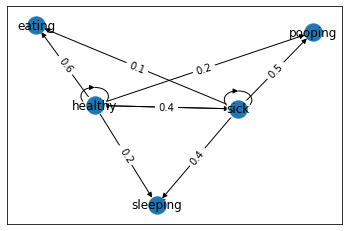

In [29]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(hidden_states)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent hidden probabilities
for k, v in hide_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

# edges represent emission probabilities
for k, v in emit_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
    
print(f'Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='neato')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
emit_edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=emit_edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_hidden_markov.dot')


- e.g. p(healthy | eating) = 0.6
- p(sick | eating) = 0.1 ??

## **Sequence of Observations and Viterbi**

In [31]:
obs_map = {'sleeping':0, 'eating':1, 'pooping':2}
obs = np.array([1,1,2,1,0,1,2,1,0,2,2,0,1,0,1])

inv_obs_map = dict((v,k) for k, v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs)]

print( pd.DataFrame(np.column_stack([obs, obs_seq]), 
                columns=['Obs_code', 'Obs_seq']) )

   Obs_code   Obs_seq
0         1    eating
1         1    eating
2         2   pooping
3         1    eating
4         0  sleeping
5         1    eating
6         2   pooping
7         1    eating
8         0  sleeping
9         2   pooping
10        2   pooping
11        0  sleeping
12        1    eating
13        0  sleeping
14        1    eating


- with Viterbi we can identify the most likely sequence of hidden states given the sequence of observations
- increments over each time step, finding the max probability of any path that gets to state i at time t
- keeps track of the state with the highest probability at each stage, at the end of the sequence, the algorithm iterates backwards selecting the state that won, creating the most likely path (sequence of hidden states that lead to the sequence of observations)

In [38]:
## kein plan wie das geht lol

def viterbi(hidden_probs, T_hidden, E_hidden, obs):
    
    nStates = np.shape(E_hidden)[0]
    T = np.shape(obs)[0]
    
    # init blank path
    path = np.zeros(T)
    # delta --> highest probability of any path that reaches state i
    delta = np.zeros((nStates, T))
    # phi --> argmax by time step for each state
    phi = np.zeros((nStates, T))
    
    # init delta and phi 
    delta[:, 0] = hidden_probs * E_hidden[:, obs[0]]
    phi[:, 0] = 0

    print('\nStart Walk Forward\n')    
    # the forward algorithm extension
    for t in range(1, T):
        for s in range(nStates):
            delta[s, t] = np.max(delta[:, t-1] * T_hidden[:, s]) * E_hidden[s, obs[t]] 
            phi[s, t] = np.argmax(delta[:, t-1] * T_hidden[:, s])
            print('s={s} and t={t}: phi[{s}, {t}] = {phi}'.format(s=s, t=t, phi=phi[s, t]))
    
    # find optimal path
    print('-'*50)
    print('Start Backtrace\n')
    path = np.zeros(T, dtype=int)
    path[T-1] = np.argmax(delta[:, T-1])
    #p('init path\n    t={} path[{}-1]={}\n'.format(T-1, T, path[T-1]))
    for t in range(T-2, -1, -1):
        path[t] = phi[path[t+1], [t+1]]
        #p(' '*4 + 't={t}, path[{t}+1]={path}, [{t}+1]={i}'.format(t=t, path=path[t+1], i=[t+1]))
        print('path[{}] = {}'.format(t, path[t]))
        
    return path, delta, phi

path, delta, phi = viterbi(hidden_probs, T_hidden.values, E.values, obs)
print('\nsingle best state path: \n', path)
print('delta:\n', delta)
print('phi:\n', phi)


Start Walk Forward

s=0 and t=1: phi[0, 1] = 0.0
s=1 and t=1: phi[1, 1] = 0.0
s=0 and t=2: phi[0, 2] = 0.0
s=1 and t=2: phi[1, 2] = 0.0
s=0 and t=3: phi[0, 3] = 0.0
s=1 and t=3: phi[1, 3] = 1.0
s=0 and t=4: phi[0, 4] = 0.0
s=1 and t=4: phi[1, 4] = 0.0
s=0 and t=5: phi[0, 5] = 0.0
s=1 and t=5: phi[1, 5] = 1.0
s=0 and t=6: phi[0, 6] = 0.0
s=1 and t=6: phi[1, 6] = 0.0
s=0 and t=7: phi[0, 7] = 0.0
s=1 and t=7: phi[1, 7] = 1.0
s=0 and t=8: phi[0, 8] = 0.0
s=1 and t=8: phi[1, 8] = 0.0
s=0 and t=9: phi[0, 9] = 0.0
s=1 and t=9: phi[1, 9] = 1.0
s=0 and t=10: phi[0, 10] = 1.0
s=1 and t=10: phi[1, 10] = 1.0
s=0 and t=11: phi[0, 11] = 1.0
s=1 and t=11: phi[1, 11] = 1.0
s=0 and t=12: phi[0, 12] = 1.0
s=1 and t=12: phi[1, 12] = 1.0
s=0 and t=13: phi[0, 13] = 0.0
s=1 and t=13: phi[1, 13] = 0.0
s=0 and t=14: phi[0, 14] = 0.0
s=1 and t=14: phi[1, 14] = 1.0
--------------------------------------------------
Start Backtrace

path[13] = 0
path[12] = 0
path[11] = 1
path[10] = 1
path[9] = 1
path[8] = 1
pat

In [39]:
state_map = {0:'healthy', 1:'sick'}
state_path = [state_map[v] for v in path]

(pd.DataFrame()
 .assign(Observation=obs_seq)
 .assign(Best_Path=state_path))

,Observation,Best_Path
0,eating,healthy
1,eating,healthy
2,pooping,healthy
3,eating,healthy
4,sleeping,healthy
5,eating,healthy
6,pooping,healthy
7,eating,healthy
8,sleeping,sick
9,pooping,sick


## **HMM (GMM?????) for Regime Detection**
- most of the time: nonstationary time series (expected mean and volatility changes over time)
- most time series model assume that time series is stationary (weakness)
- better: assume that time series have temporary periods where the expected mean and varainces are stable through time --> these regimes/periods could be seen as hidden states
- if we can asses the most likely regime (with means and variances), then the model is more adaptive
- but we need observable variables whose behavior allows us to infer the true hidden states


- **observable states here**: asset returns, ted spread, 10 year/2year constant maturity sprread, 10-3 month constant maturity spread

In [45]:
import pandas as pd
import pandas_datareader.data as web
import sklearn.mixture as mix

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
import missingno as msno
from tqdm import tqdm

/tmp/ipykernel_21878/3234290373.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime.today()


            TEDRATE  T10Y2Y  T10Y3M        SPY      sret
2002-01-03     0.18    1.97    3.43  80.170029  0.011276
2002-01-04     0.18    1.99    3.46  80.705246  0.006654
2002-01-07     0.21    2.01    3.41  80.135719 -0.007082
2002-01-08     0.19    2.03    3.42  79.950439 -0.002315
2002-01-09     0.19    2.07    3.42  79.298599 -0.008186


<AxesSubplot:>

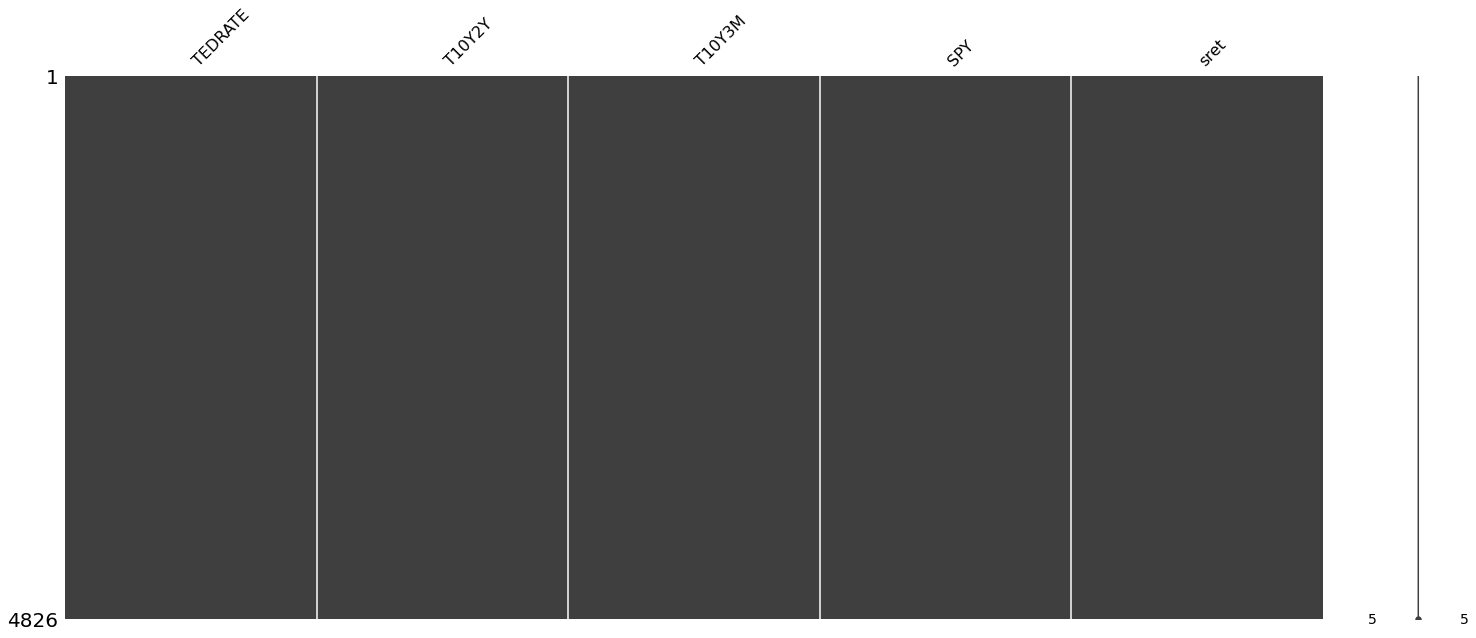

In [47]:
# get fed data

f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m

start = pd.to_datetime('2002-01-01')
end = pd.datetime.today()

mkt = 'SPY'
MKT = (web.DataReader([mkt], 'yahoo', start, end)['Adj Close']
       .rename(columns={mkt:mkt})
       .assign(sret=lambda x: np.log(x[mkt]/x[mkt].shift(1)))
       .dropna())

data = (web.DataReader([f1, f2, f3], 'fred', start, end)
        .join(MKT, how='inner')
        .dropna()
       )

print(data.head())

# gives us a quick visual inspection of the data
msno.matrix(data)


Next we will use the sklearn's GaussianMixture to fit a model that estimates these regimes. We will explore mixture models  in more depth in part 2 of this series. The important takeaway is that mixture models implement a closely related unsupervised form of density estimation. It makes use of the expectation-maximization algorithm to estimate the means and covariances of the hidden states (regimes). For now, it is ok to think of it as a magic button for guessing the transition and emission probabilities, and most likely path. 

We have to specify the number of components for the mixture model to fit to the time series. In this example the components can be thought of as regimes. We will arbitrarily classify the regimes as High, Neutral and Low Volatility and set the number of components to three.

In [54]:
data.head()

,TEDRATE,T10Y2Y,T10Y3M,SPY,sret
2002-01-03,0.18,1.97,3.43,80.170029,0.011276
2002-01-04,0.18,1.99,3.46,80.705246,0.006654
2002-01-07,0.21,2.01,3.41,80.135719,-0.007082
2002-01-08,0.19,2.03,3.42,79.950439,-0.002315
2002-01-09,0.19,2.07,3.42,79.298599,-0.008186


In [57]:
print(data.shape)

(4826, 5)


In [58]:
col = 'sret'
select = data.dropna()

ft_cols = [f1, f2, f3, 'sret']
X = select[ft_cols]
X.head()

,TEDRATE,T10Y2Y,T10Y3M,sret
2002-01-03,0.18,1.97,3.43,0.011276
2002-01-04,0.18,1.99,3.46,0.006654
2002-01-07,0.21,2.01,3.41,-0.007082
2002-01-08,0.19,2.03,3.42,-0.002315
2002-01-09,0.19,2.07,3.42,-0.008186


In [59]:
# create a gaussian mixture model for 3 components given the training set
model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)


In [67]:
test = np.array([[0.18, 1.97, 3.43, 0.011]])
model.predict(test)

array([2])

In [70]:
model.sample(n_samples=3)

(array([[ 3.76388974e-01,  1.15346932e+00,  1.96598622e+00,
          3.45103514e-03],
        [ 3.68551050e-01,  1.65119421e-01,  1.95645795e-01,
         -1.08918516e-02],
        [ 1.57726578e-01,  2.59047540e+00,  3.17615173e+00,
         -9.30998626e-04]]),
 array([1, 1, 2]))

In [72]:
model.predict(X)

# model predictions are like clusters but with GMM you can also create new instances
# GMM is a MODEL that tries to estimate the distribution, KMeans is an algorithm that does clustering
# predictions can be seen as the hidden states

array([2, 2, 2, ..., 1, 1, 1])

**Gaussian Mixture Model with 3 components over given financial data**

In [74]:
model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)
n_components=3
# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print('There are {} hidden states, comparable to clusters'.format(n_components))
print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))

#these are the mean value and variance of the gaussian distribution on each component

There are 3 hidden states, comparable to clusters
Means and vars of each hidden state
0th hidden state
mean =  [ 1.01452634e+00  1.48128769e+00  1.91078617e+00 -1.84658193e-03]
var =  [5.16650468e-01 4.28470002e-01 9.12864899e-01 5.58945381e-04]

1th hidden state
mean =  [0.35299162 0.4962689  0.74842641 0.00101526]
var =  [2.12628975e-02 1.94121119e-01 4.97391202e-01 4.66711490e-05]

2th hidden state
mean =  [2.25889190e-01 2.03195025e+00 2.61248469e+00 4.31310967e-04]
var =  [3.96242469e-03 2.29968669e-01 4.12927280e-01 8.83414782e-05]



- 1st hidden state has largest expected return (last number there) and smallest variance!

**plot the SRETURN**

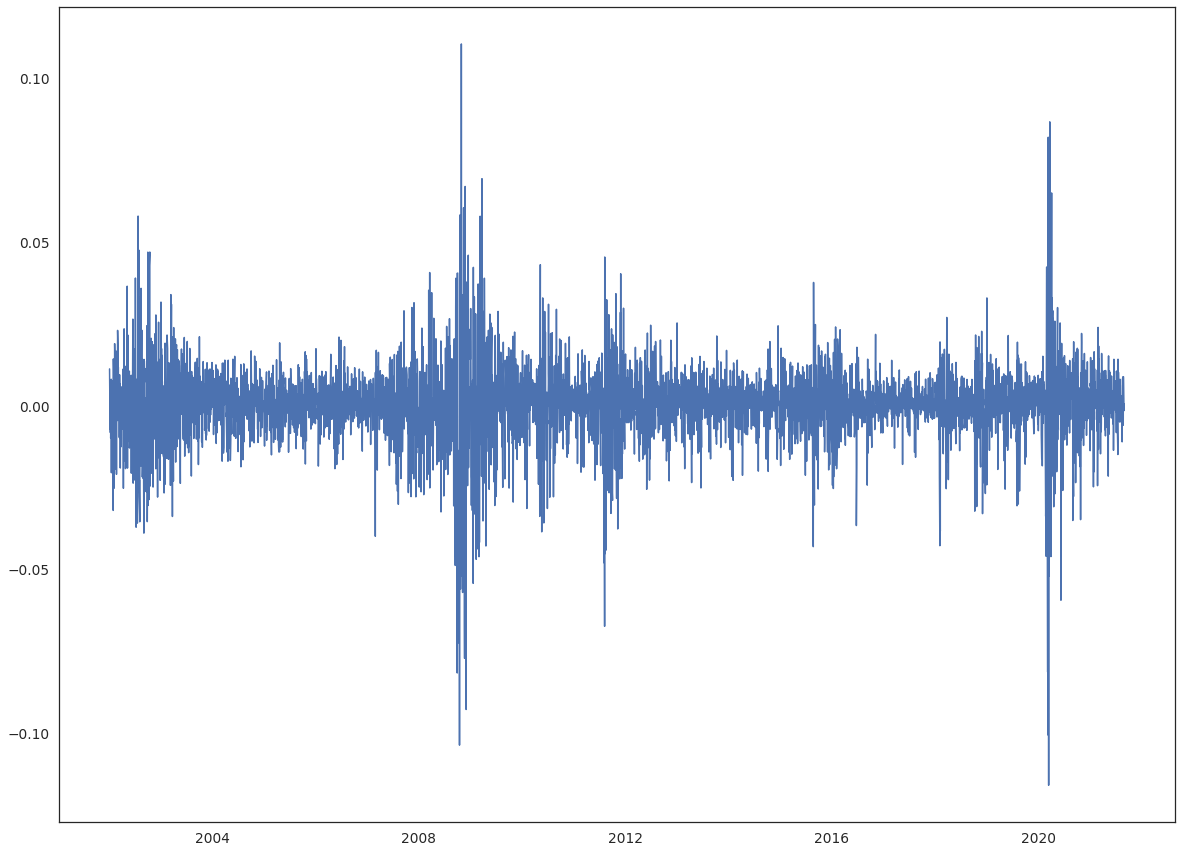

In [78]:
plt.figure(figsize=(20,15))
plt.plot(select['sret'])

**plot with colors for states found with HMM**

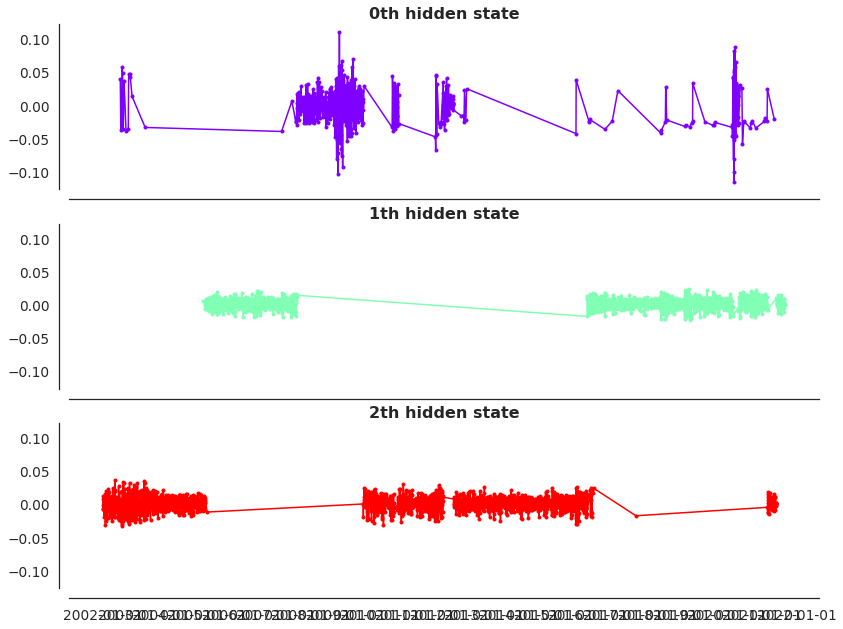

In [79]:
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()

<function matplotlib.pyplot.show(close=None, block=None)>

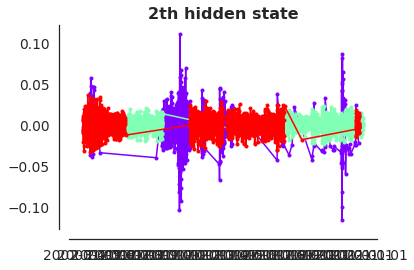

In [88]:
# in one graph
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

colors = cm.rainbow(np.linspace(0, 1, model.n_components))
fig, ax = plt.subplots()
for i, color in enumerate(colors):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
plt.show

/home/lukas/miniconda3/envs/env-03/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


        Date  states  TEDRATE  T10Y2Y  T10Y3M        SPY      sret  mkt_cret
0 2002-01-03       2     0.18    1.97    3.43  80.170029  0.011276  0.011276
1 2002-01-04       2     0.18    1.99    3.46  80.705246  0.006654  0.017929
2 2002-01-07       2     0.21    2.01    3.41  80.135719 -0.007082  0.010848
3 2002-01-08       2     0.19    2.03    3.42  79.950439 -0.002315  0.008533
4 2002-01-09       2     0.19    2.07    3.42  79.298599 -0.008186  0.000346


findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


Text(0.5, 0.98, 'Historical SPY Regimes')

findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


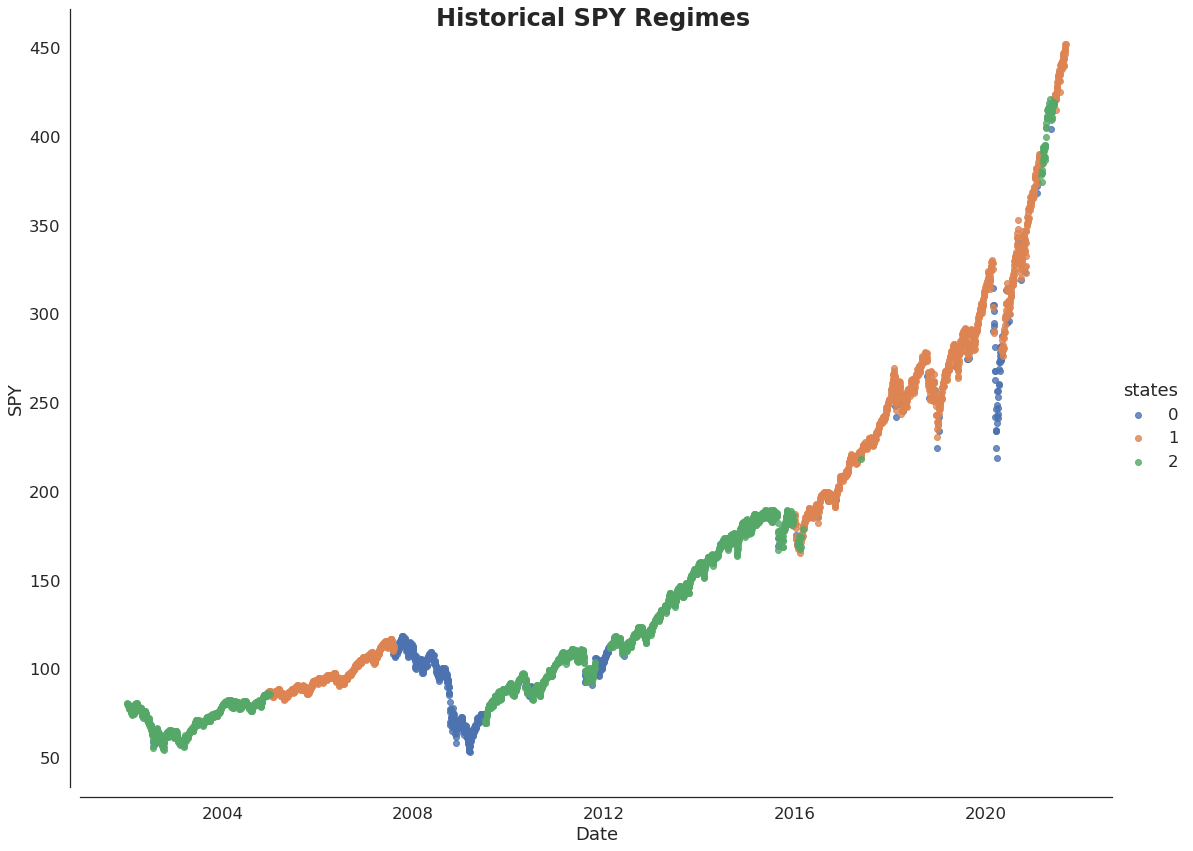

In [53]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=select.index)
          .join(select, how='inner')
          .assign(mkt_cret=select.sret.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
print(states.head())

sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                  aspect=1.31, size=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SPY Regimes', fontsize=24, fontweight='demi')